# Soiling detection and regression

### This notebook is fifth in the series of soiling detection pipeline notebooks (following step after the notebook <font color='green'>bad_day_filter.ipynb</font>)

Author: Lina Siegrist

In [5]:
import pandas as pd
import numpy as np
import copy
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

## Import data from previous steps

### EPI with preprocessed, time masked, big-drop filtered and bad-day filtered

In [6]:
root_path = "../data/temp/park2/bad_day_filter/"
EPI_dropsfilt_baddayfilt_filepath = root_path + "EPI_dropsfilt_baddayfilt.csv"

In [7]:
def read_data(EPI_dropsfilt_baddayfilt_filepath):
    EPI_dropsfilt_baddayfilt = pd.read_csv(EPI_dropsfilt_baddayfilt_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
    return EPI_dropsfilt_baddayfilt

In [8]:
EPI_dropsfilt_baddayfilt = read_data(EPI_dropsfilt_baddayfilt_filepath)

## Import environmental data

In [9]:
root_path_2 = "../data/raw/New_data/"
env_data_filepath = root_path_2 + "Solarpark2_Oct_2019_Oct2020_environmental.csv"

In [10]:
def read_data(env_data_filepath):
    df_env = pd.read_csv(env_data_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
    return df_env

In [11]:
df_env = read_data(env_data_filepath)
df_env.columns = ['Temp_A', 'Temp_P', 'Irradiance']

Rename columns, merge environment and capacity dfs, remove RCB columns (NAs only)

In [12]:
# Calculate the daily irradiance, required for the soiling calculation using RdTools
daily_irr = df_env['Irradiance'].resample('D').sum()

## <font color='orange'>↓ Beginning of 'Using functions in RdTools'</font>

## Calculate daily median EPI of all strings

### 1. Data for whole period

In [16]:
EPI_dropsfilt_baddayfilt['median_EPI'] = EPI_dropsfilt_baddayfilt.loc[:,:].median(axis=1)
EPI_dropsfilt_baddayfilt_daily_median = EPI_dropsfilt_baddayfilt[['median_EPI']]
EPI_dropsfilt_baddayfilt_daily_median_series = EPI_dropsfilt_baddayfilt_daily_median['median_EPI']
# Next line is: to avoid this error: ValueError: Daily performance metric series must have daily frequency
EPI_dropsfilt_baddayfilt_daily_median_series = EPI_dropsfilt_baddayfilt_daily_median_series.resample('D').mean() 

In [18]:
# data of whole period
EPI_dropsfilt_baddayfilt_daily_median_series

## Perfome soiling calculation

### 1. Data for whole period

In [33]:
import rdtools
from rdtools.soiling import soiling_srr
cl = 68.2
# whole data
sr, sr_ci, soiling_info = soiling_srr(EPI_dropsfilt_baddayfilt_daily_median_series, daily_irr, confidence_level=cl, day_scale=26, max_relative_slope_error=100.0)

## Plot using function in RdTools

### LINA's note: Here I disassembled soiling_interval_plot() function to modify input arguments.

In [149]:
# # Plot Monte Carlo realizations of soiling profiles (function from RdTools)
# fig = rdtools.plotting.soiling_monte_carlo_plot(soiling_info, df_BDfilt_dayfilt_daily_median_series, profiles=200);

In [150]:
# Plot the slopes for "valid" soiling intervals identified, assuming perfect cleaning events (function from RdTools)
# fig = rdtools.plotting.soiling_interval_plot(soiling_info, df_BDfilt_dayfilt_daily_median_series);

### Data for whole period

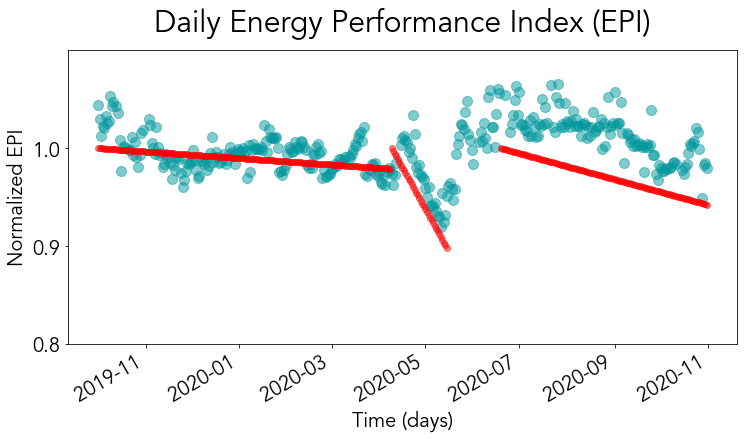

In [20]:
# def soiling_interval_plot(soiling_info, normalized_yield, point_alpha=0.5,
#                           profile_alpha=1, ymin=None, ymax=None,
#                           point_color=None, profile_color=None):

ymin=0.8
ymax=1.1

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
afont = {'fontname':'Avenir'}

sratio = soiling_info['soiling_ratio_perfect_clean']
renormalized = EPI_dropsfilt_baddayfilt_daily_median_series / soiling_info['renormalizing_factor'] 

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(renormalized.index,renormalized,'o',alpha=0.5,markersize=10, color='#03989e')
ax.plot(sratio.index, sratio, 'o',color='r',alpha=0.5, label='Soiling ratio') 
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin,1.05,0.1),minor=False)
ax.set_ylabel('Normalized EPI',fontsize=20, **afont)
ax.set_xlabel('Time (days)',fontsize=20, **afont)
plt.xticks(**afont)
plt.yticks(**afont)
ax.set_title('Daily Energy Performance Index (EPI)',pad = 20, fontsize=30, **afont)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
fig.autofmt_xdate();
# fig.savefig('EPI.png');

## Calculate soiling loss

In [29]:
daily_soiling_loss = 1 - EPI_dropsfilt_baddayfilt_daily_median_series

In [30]:
sratio = soiling_info['soiling_ratio_perfect_clean']

In [31]:
sloss = 1 - sratio

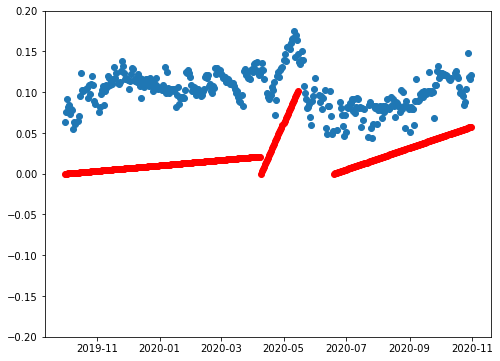

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(daily_soiling_loss.index, daily_soiling_loss,'o')
ax.plot(sloss.index, sloss, 'o', color='r')
ax.set_ylim(-0.2, 0.2);

## Outputs from soiling_srr() function

In [49]:
sr

In [50]:
sr_ci

In [51]:
soiling_info['exceedance_level']

In [52]:
soiling_info['renormalizing_factor']

In [53]:
soiling_info['renormalizing_factor']

In [61]:
soiling_info['stochastic_soiling_profiles']

In [63]:
soiling_rate = soiling_info['soiling_ratio_perfect_clean']

## Soiling interval summary table

In [25]:
soiling_summary = soiling_info['soiling_interval_summary']
soiling_summary

,start,end,soiling_rate,soiling_rate_low,soiling_rate_high,inferred_start_loss,inferred_end_loss,length,valid
0,2019-10-01,2020-04-08,-0.000111,-0.000156,-0.000064,1.004156,0.983158,190,True
1,2020-04-09,2020-05-15,-0.002834,-0.003372,-0.001931,1.023935,0.921914,36,True
2,2020-05-16,2020-05-21,0.000000,0.000000,0.000000,0.960160,0.960057,5,False
3,2020-05-22,2020-05-27,0.000000,0.000000,0.000000,1.006590,1.036967,5,False
4,2020-05-28,2020-06-05,0.000000,0.000000,0.000000,1.032701,0.951616,8,False
5,2020-06-06,2020-06-11,0.000000,0.000000,0.000000,1.009999,1.016764,5,False
6,2020-06-12,2020-06-16,0.000000,0.000000,0.000000,1.038093,1.005833,4,False
7,2020-06-17,2020-06-18,0.000000,0.000000,0.000000,1.058233,1.058233,1,False
8,2020-06-19,2020-10-31,-0.000430,-0.000515,-0.000345,1.046202,0.988632,134,True


In [91]:
# soiling_summary.to_csv("soiling_summary_park1.csv")

## Histogram of the valid soiling rates found for the data set

In [27]:
# fig = rdtools.plotting.soiling_rate_histogram(soiling_info, bins=50)

## Calculate and view a monthly soiling rate summary

In [28]:
from rdtools.soiling import monthly_soiling_rates
monthly_soiling_summary = monthly_soiling_rates(soiling_info['soiling_interval_summary'], confidence_level=cl)
monthly_soiling_summary

,month,soiling_rate_median,soiling_rate_low,soiling_rate_high,interval_count
0,1,-0.000110,-0.000141,-0.000079,1
1,2,-0.000110,-0.000141,-0.000079,1
2,3,-0.000110,-0.000141,-0.000079,1
3,4,-0.002389,-0.003062,-0.000119,2
4,5,-0.002648,-0.003142,-0.002155,1
5,6,-0.000430,-0.000488,-0.000372,1
6,7,-0.000430,-0.000488,-0.000372,1
7,8,-0.000430,-0.000488,-0.000372,1
8,9,-0.000430,-0.000488,-0.000372,1
9,10,-0.000250,-0.000461,-0.000093,2


In [95]:
# monthly_soiling_summary.to_csv("monthly_soiling_summary_park1.csv")

## <font color='orange'>↑ End of 'Using functions in RdTools'</font>

## Generate a dataframe of soiling rate for each string

### Data for whole period

In [92]:
df_soiling = copy.deepcopy(EPI_dropsfilt_baddayfilt)
list = df_soiling.columns
df_soiling = df_soiling.drop(list, axis = 1)

In [190]:
for name in EPI_dropsfilt_baddayfilt.keys():
    soiling = EPI_dropsfilt_baddayfilt[name]
    cl = 68.2
    sr, sr_ci, soiling_info = soiling_srr(soiling, daily_irr, confidence_level=cl, day_scale=20)
    df_soiling[name] = soiling_info['soiling_ratio_perfect_clean']

In [107]:
# # export
# df_soiling.to_csv('park1_soiling_rate_per_string.csv')

In [301]:
# # import
# df_soiling = pd.read_csv("../data/processed/park1/park1_soiling_rate_per_string.csv")
# df_soiling['datetime'] = pd.to_datetime(df_soiling['datetime'], format='%Y-%m-%d %H')
# df_soiling.set_index('datetime', drop = True, inplace = True)

## Plot: Soiling rate for each string

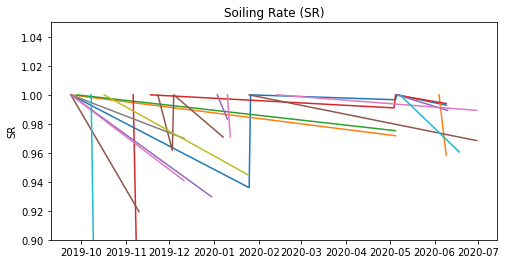

In [138]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df_soiling.index, df_soiling.iloc[:,:10])
ax.set_ylabel('SR')
ax.set_title('Soiling Rate (SR)')
ax.set_ylim(0.9,1.05);

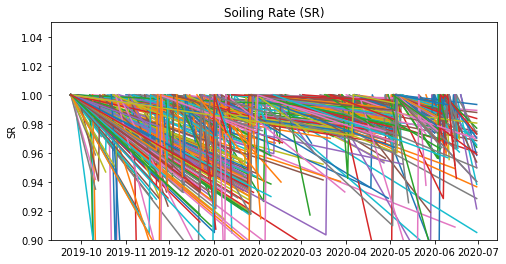

In [104]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df_soiling.index, df_soiling)
ax.set_ylabel('SR')
ax.set_title('Soiling Rate (SR)')
ax.set_ylim(0.9,1.05);